### Задача

**Компания х запросила разработку модели для предсказания успешности стартапа.   
Датасет состоит из двух файлов: тренировочный набор (около 53к записей) и тестовый набор (около 13к записей). 
Тренировочный набор содержит целевой признак status, указывающий на то, закрылся стартап или продолжает действовать. Временной период - '1970-01-01' по '2018-01-01'. Дата формирования выгрузки - '2018-01-01'
Для анализа точности прогноза модели воспользуемся метрикой F1-Score, которая вычисляется на основе точности p и полноты r.**

## 1. Загрузка данных

In [1]:
from IPython.display import display
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import datetime
from datetime import date, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import (
    train_test_split, 
    RandomizedSearchCV, 
    GridSearchCV
)
from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder, 
    OrdinalEncoder, 
    MinMaxScaler, 
    PolynomialFeatures
)
from sklearn.linear_model import (
    LogisticRegression
)
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score, make_scorer
)
from sklearn.svm import SVC
import seaborn as sns
import scipy.stats as st
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import phik
import shap
from phik import phik_matrix
from phik.report import plot_correlation_matrix
import time

In [2]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
f1 = make_scorer(f1_score , average='micro')
def lowers(data, column1, column2, column3, column4, column5, column6):
    data[column1] = data[column1].str.lower()
    data[column2] = data[column2].str.lower()
    data[column3] = data[column3].str.lower()
    data[column4] = data[column4].str.lower()
    data[column5] = data[column5].str.lower()
    data[column6] = data[column6].str.lower()

def datetimes(data, column_1, column_2):
#    data[column_1 + '_year']= pd.DatetimeIndex(data[column_1]).year
#    data[column_1 + '_month']= pd.DatetimeIndex(data[column_1]).month
    data[column_2 + '_year']= pd.DatetimeIndex(data[column_2]).year
#    data[column_2 + '_month']= pd.DatetimeIndex(data[column_2]).month
#    data[column_1 + '_'] = data[column_1 + '_year'].apply(lambda x: str(x)) + data[column_1 + '_month'].apply(lambda x: str(x))
#    data[column_2 + '_'] = data[column_2 + '_year'].apply(lambda x: str(x)) + data[column_2 + '_month'].apply(lambda x: str(x))
    
    data.drop([column_1, column_2], axis= 1 , inplace= True )
    
#    data[column_2 + '_year'] = data[column_2 + '_year'].apply(lambda x: int(x))
#    data[column_2 + '_month'] = data[column_2 + '_month'].apply(lambda x: int(x))
    
#    data.drop([column_1, column_2,  column_1 + '_year',
#              column_1 + '_month', column_2 + '_year',
#              column_2 + '_month'], axis= 1 , inplace= True )
#    data[column_1 + '_'] = data[column_1 + '_'].apply(lambda x: int(x))
#    data[column_2 + '_'] = data[column_2 + '_'].apply(lambda x: int(x))
    data.drop(['region', 'city', 'state_code'],axis= 1 , inplace= True)
#    data.set_index('name', inplace = True)

In [3]:
df_train = pd.read_csv('C:/Users/ASUS/Desktop/kaggle_startups_train_28062024.csv')

In [4]:
df_test = pd.read_csv('C:/Users/ASUS/Desktop/kaggle_startups_test_28062024.csv')

In [5]:
df = pd.read_csv('C:/Users/ASUS/Desktop/kaggle_startups_sample_submit_28062024.csv')

## 2. Предобработка данных

In [6]:
df_train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.0,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.0,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.0,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52511,Videostream,Entertainment,NaN,operating,CAN,ON,Toronto,Kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN
52512,Hello Curry,Hospitality,500000.0,operating,IND,2,Hyderabad,Hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaN
52513,Taskforce,Email|Messaging|Productivity Software,50000.0,operating,USA,CA,SF Bay Area,San Francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN
52514,NetScaler,Security,13000000.0,operating,USA,CA,SF Bay Area,San Jose,6,1997-12-01,1998-11-30,2004-03-01,NaN


In [7]:
df

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating
...,...,...
13120,Jymob,operating
13121,GlobaTrek,operating
13122,Inkd.com,closed
13123,AdWill,operating


In [8]:
df_test

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.0,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.0,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.0,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.0,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209
...,...,...,...,...,...,...,...,...,...,...,...
13120,Jymob,Recruiting,28000.0,USA,CA,SF Bay Area,Sunnyvale,1,2012-07-01,2012-07-01,2267
13121,GlobaTrek,Software,NaN,USA,CA,SF Bay Area,Mountain View,1,2013-10-01,2013-10-01,2192
13122,Inkd.com,Design|E-Commerce|Marketplaces|Printing,5600000.0,USA,WA,Seattle,Seattle,3,2008-09-01,2011-06-28,2922
13123,AdWill,Advertising Exchanges|Mobile|Mobile Advertising,150000.0,USA,NY,New York City,New York,2,2014-09-27,2014-11-04,1386


In [9]:
df_train.describe()

,funding_total_usd,funding_rounds
count,4.244700e+04,52516.000000
mean,1.824748e+07,1.740670
std,1.871173e+08,1.374522
min,1.000000e+00,1.000000
25%,3.360275e+05,1.000000
50%,2.000000e+06,1.000000
75%,1.000000e+07,2.000000
max,3.007950e+10,19.000000


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB


In [11]:
#for t in df_train['country_code'].unique():
#    df_train.loc[(df_train['country_code'] == t) & (df_train['funding_total_usd'].isna()), 'funding_total_usd'] = \
#    df_train.loc[(df_train['country_code'] == t), 'funding_total_usd'].median()

In [12]:
ha = df_train.query('funding_total_usd > 100000000')

In [13]:
df_train = df_train.query('@df_train.index not in @ha.index')

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 51278 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               51277 non-null  object 
 1   category_list      48825 non-null  object 
 2   funding_total_usd  41209 non-null  float64
 3   status             51278 non-null  object 
 4   country_code       45835 non-null  object 
 5   state_code         44598 non-null  object 
 6   region             44995 non-null  object 
 7   city               44995 non-null  object 
 8   funding_rounds     51278 non-null  int64  
 9   founded_at         51278 non-null  object 
 10  first_funding_at   51278 non-null  object 
 11  last_funding_at    51278 non-null  object 
 12  closed_at          4849 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.5+ MB


<Axes: xlabel='funding_total_usd', ylabel='status'>

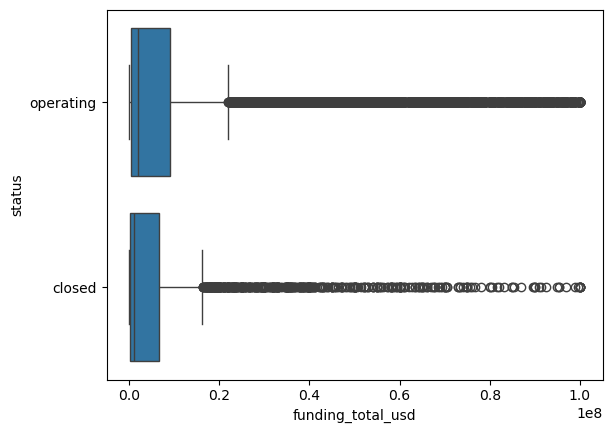

In [15]:
sns.boxplot(data = df_train, x = 'funding_total_usd', orient ='h', y = 'status')

<Axes: xlabel='funding_rounds', ylabel='status'>

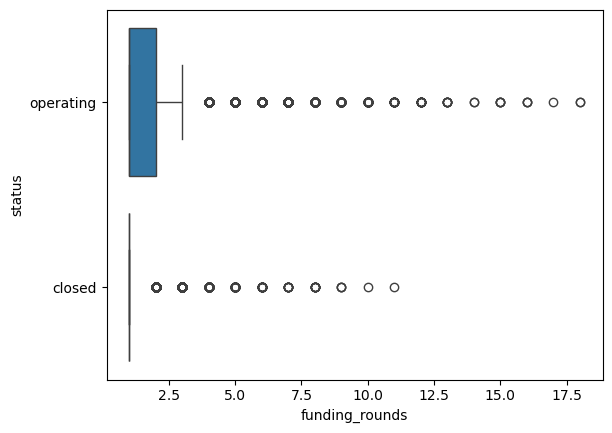

In [16]:
sns.boxplot(data = df_train, x = 'funding_rounds', orient ='h', y = 'status')

In [17]:
df_train = df_train.query('funding_rounds<=5')

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50237 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               50236 non-null  object 
 1   category_list      47787 non-null  object 
 2   funding_total_usd  40177 non-null  float64
 3   status             50237 non-null  object 
 4   country_code       44813 non-null  object 
 5   state_code         43580 non-null  object 
 6   region             43977 non-null  object 
 7   city               43977 non-null  object 
 8   funding_rounds     50237 non-null  int64  
 9   founded_at         50237 non-null  object 
 10  first_funding_at   50237 non-null  object 
 11  last_funding_at    50237 non-null  object 
 12  closed_at          4804 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.4+ MB


In [19]:
df_train[df_train['name'].isna()]
df_train = df_train.dropna(subset='name')
display(df_train[df_train['name'].isna()])
df_train.duplicated(subset='name').sum()

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at


0

In [20]:
df_train['category_list'].unique()

array(['Online Reservations|Restaurants',
       'Manufacturing|Medical|Medical Devices', 'Biotechnology', ...,
       'Gambling|Games|Online Gaming|Sports',
       'Aerospace|Mobile|Transportation|Travel',
       'Online Rental|Parking|Price Comparison'], dtype=object)

In [21]:
df_train['category_list'] = df_train['category_list'].str.replace(' ', '_')
df_test['category_list'] = df_test['category_list'].str.replace(' ', '_',)

In [22]:
lowers(df_train,'name', 'category_list', 'country_code', 'state_code', 'region', 'city')

In [23]:
lowers(df_test,'name', 'category_list', 'country_code', 'state_code', 'region', 'city')

In [24]:
df_train['status'].unique()

array(['operating', 'closed'], dtype=object)

In [25]:
df_train['country_code'].unique()

array(['che', 'usa', nan, 'gbr', 'rus', 'esp', 'fra', 'swe', 'ind', 'kor',
       'aus', 'twn', 'chn', 'hun', 'can', 'fin', 'bra', 'egy', 'prt',
       'chl', 'isr', 'svk', 'nld', 'arg', 'are', 'jpn', 'irl', 'deu',
       'lbn', 'est', 'idn', 'bel', 'mex', 'dnk', 'ita', 'grc', 'rom',
       'tur', 'sgp', 'sau', 'mys', 'nga', 'qat', 'vnm', 'bgr', 'gha',
       'uga', 'jor', 'aut', 'pak', 'nzl', 'hkg', 'zaf', 'lva', 'nor',
       'hrv', 'ven', 'per', 'lux', 'svn', 'pol', 'phl', 'nic', 'cze',
       'isl', 'pan', 'ury', 'bgd', 'mco', 'gtm', 'tha', 'tto', 'ukr',
       'cri', 'dza', 'ltu', 'cym', 'mus', 'blr', 'slv', 'ken', 'col',
       'mlt', 'pse', 'blz', 'cyp', 'mmr', 'mkd', 'khm', 'gib', 'srb',
       'dom', 'bwa', 'blm', 'pry', 'bmu', 'tan', 'lie', 'uzb', 'geo',
       'sen', 'alb', 'ecu', 'moz', 'lka', 'lao', 'tun', 'hnd', 'zwe',
       'bah', 'mda', 'maf', 'bhr', 'aze', 'mar', 'kwt', 'irn', 'ggy',
       'kna', 'pri', 'omn', 'kaz', 'jam', 'npl', 'arm', 'rwa', 'brn',
       'jey', '

In [26]:
df_train['state_code'].unique()

array(['25', 'ca', nan, 'va', 'nj', 'tx', 'or', 'fl', 'wa', 'ny', 'c7',
       'az', '91', 'ga', 'ma', 'pa', 'mi', '56', 'mn', 'a8', 'de', '26',
       'q5', '7', 'ri', '11', 'c5', 'co', '3', '23', '1', 'on', 'il',
       'oh', 'k2', '2', '14', '30', 'h9', 'al', '29', '6', 'nc', '12',
       '22', 'md', '5', '48', 'nd', '40', 'k4', 'vt', '16', '4', 'ut',
       'in', '8', '9', '18', 'ct', '13', 'nv', '10', 'b8', '27', '17',
       'ia', 'wi', 'l9', 'nm', 'b7', 'mo', 'bc', '21', 'f7', 'me', 'nh',
       '35', 'ns', 'c1', 'c3', 'sc', '20', 'tn', 'a6', '51', 'i7', 'la',
       'ks', '42', 'n7', 'u8', 'i2', 'ar', 'ne', '41', 'qc', 'ab', '37',
       '15', '19', '97', 'v2', 'd2', 'dc', 'a7', 'c9', 'f8', 'y2', 'b9',
       'j7', 'm9', 'g2', 'h3', 'nb', '28', 'v8', '34', 'b5', 'f2', 'a9',
       'z7', '53', 'h8', 'mt', 'id', 'mb', 'ky', '61', '60', 'b4', '82',
       'a2', 'c8', 'l3', 'd9', 'm3', 'ms', '31', '33', '52', 'ak', '78',
       '72', 'q4', 'y4', 'wy', '32', 'e6', 'q3', 'f9', '24', 

In [27]:
df_train['region'].unique().shape

(1033,)

In [28]:
df_train['city'].unique().shape

(4427,)

In [29]:
df_train['funding_rounds'].unique()

array([2, 4, 3, 1, 5], dtype=int64)

In [30]:
unload_date = date(2018, 1, 1)

In [31]:
df_train['unload_date'] = unload_date

In [32]:
df_train['founded_at'] = pd.to_datetime(df_train['founded_at'])
df_train['unload_date'] = pd.to_datetime(df_train['unload_date'])
df_train['first_funding_at'] = pd.to_datetime(df_train['first_funding_at'])
df_train['last_funding_at'] = pd.to_datetime(df_train['last_funding_at'])

In [33]:
 df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50236 entries, 0 to 52515
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   name               50236 non-null  object        
 1   category_list      47786 non-null  object        
 2   funding_total_usd  40176 non-null  float64       
 3   status             50236 non-null  object        
 4   country_code       44812 non-null  object        
 5   state_code         43579 non-null  object        
 6   region             43976 non-null  object        
 7   city               43976 non-null  object        
 8   funding_rounds     50236 non-null  int64         
 9   founded_at         50236 non-null  datetime64[ns]
 10  first_funding_at   50236 non-null  datetime64[ns]
 11  last_funding_at    50236 non-null  datetime64[ns]
 12  closed_at          4803 non-null   object        
 13  unload_date        50236 non-null  datetime64[ns]
dtypes: datetime

In [34]:
df_train['lifetime'] = (df_train['unload_date'] - df_train['founded_at'])

In [35]:
df_train['lifetime'] = df_train['lifetime'].apply(lambda x: x.days)

In [36]:
df_train

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at,unload_date,lifetime
0,lunchgate,online_reservations|restaurants,828626.0,operating,che,25,zurich,zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN,2018-01-01,2998
1,earlens,manufacturing|medical|medical_devices,42935019.0,operating,usa,ca,sf bay area,redwood city,4,2005-01-01,2010-05-04,2014-02-25,NaN,2018-01-01,4748
2,reviva pharmaceuticals,biotechnology,35456381.0,operating,usa,ca,sf bay area,san jose,3,2006-01-01,2012-08-20,2014-07-02,NaN,2018-01-01,4383
3,sancilio and company,health_care,22250000.0,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN,2018-01-01,5114
4,wiretough cylinders,manufacturing,NaN,operating,usa,va,va - other,bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN,2018-01-01,2791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52509,visionary mobile,biotechnology,1570000.0,operating,usa,or,"salem, oregon",corvallis,3,2010-01-01,2011-09-20,2012-04-11,NaN,2018-01-01,2922
52511,videostream,entertainment,NaN,operating,can,on,toronto,kitchener,1,2012-01-01,2014-03-01,2014-03-01,NaN,2018-01-01,2192
52512,hello curry,hospitality,500000.0,operating,ind,2,hyderabad,hyderabad,1,2013-08-25,2014-03-07,2014-03-07,NaN,2018-01-01,1590
52513,taskforce,email|messaging|productivity_software,50000.0,operating,usa,ca,sf bay area,san francisco,3,2010-07-01,2009-06-14,2011-01-01,NaN,2018-01-01,2741


In [37]:
df_test.columns.tolist()

['name',
 'category_list',
 'funding_total_usd',
 'country_code',
 'state_code',
 'region',
 'city',
 'funding_rounds',
 'first_funding_at',
 'last_funding_at',
 'lifetime']

In [38]:
df_train.columns.tolist()

['name',
 'category_list',
 'funding_total_usd',
 'status',
 'country_code',
 'state_code',
 'region',
 'city',
 'funding_rounds',
 'founded_at',
 'first_funding_at',
 'last_funding_at',
 'closed_at',
 'unload_date',
 'lifetime']

In [39]:
df_y = df_train[['name', 'status']]

In [40]:
df_train = df_train[df_test.columns.tolist()]

In [41]:
df_train = df_train.merge(df_y, on = 'name')

In [42]:
df_train

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime,status
0,lunchgate,online_reservations|restaurants,828626.0,che,25,zurich,zürich,2,2011-05-01,2014-12-01,2998,operating
1,earlens,manufacturing|medical|medical_devices,42935019.0,usa,ca,sf bay area,redwood city,4,2010-05-04,2014-02-25,4748,operating
2,reviva pharmaceuticals,biotechnology,35456381.0,usa,ca,sf bay area,san jose,3,2012-08-20,2014-07-02,4383,operating
3,sancilio and company,health_care,22250000.0,NaN,NaN,NaN,NaN,3,2011-09-01,2014-07-18,5114,operating
4,wiretough cylinders,manufacturing,NaN,usa,va,va - other,bristol,1,2012-02-01,2012-02-01,2791,operating
...,...,...,...,...,...,...,...,...,...,...,...,...
50317,visionary mobile,biotechnology,1570000.0,usa,or,"salem, oregon",corvallis,3,2011-09-20,2012-04-11,2922,operating
50318,videostream,entertainment,NaN,can,on,toronto,kitchener,1,2014-03-01,2014-03-01,2192,operating
50319,hello curry,hospitality,500000.0,ind,2,hyderabad,hyderabad,1,2014-03-07,2014-03-07,1590,operating
50320,taskforce,email|messaging|productivity_software,50000.0,usa,ca,sf bay area,san francisco,3,2009-06-14,2011-01-01,2741,operating


In [43]:
datetimes(df_train, 'first_funding_at', 'last_funding_at')

In [44]:
df_train

,name,category_list,funding_total_usd,country_code,funding_rounds,lifetime,status,last_funding_at_year
0,lunchgate,online_reservations|restaurants,828626.0,che,2,2998,operating,2014
1,earlens,manufacturing|medical|medical_devices,42935019.0,usa,4,4748,operating,2014
2,reviva pharmaceuticals,biotechnology,35456381.0,usa,3,4383,operating,2014
3,sancilio and company,health_care,22250000.0,NaN,3,5114,operating,2014
4,wiretough cylinders,manufacturing,NaN,usa,1,2791,operating,2012
...,...,...,...,...,...,...,...,...
50317,visionary mobile,biotechnology,1570000.0,usa,3,2922,operating,2012
50318,videostream,entertainment,NaN,can,1,2192,operating,2014
50319,hello curry,hospitality,500000.0,ind,1,1590,operating,2014
50320,taskforce,email|messaging|productivity_software,50000.0,usa,3,2741,operating,2011


In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50322 entries, 0 to 50321
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  50322 non-null  object 
 1   category_list         47865 non-null  object 
 2   funding_total_usd     40241 non-null  float64
 3   country_code          44882 non-null  object 
 4   funding_rounds        50322 non-null  int64  
 5   lifetime              50322 non-null  int64  
 6   status                50322 non-null  object 
 7   last_funding_at_year  50322 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(4)
memory usage: 2.9+ MB


In [46]:
#df_train['funding_total_usd'] = pd.qcut(df_train['funding_total_usd'], q=6)

## 3. Корреляционный анализ

In [47]:
ha = df_train.drop(['name','category_list'],axis= 1)

In [48]:
num_columns = (['lifetime', 'funding_rounds','funding_total_usd',
                'last_funding_at_year'])

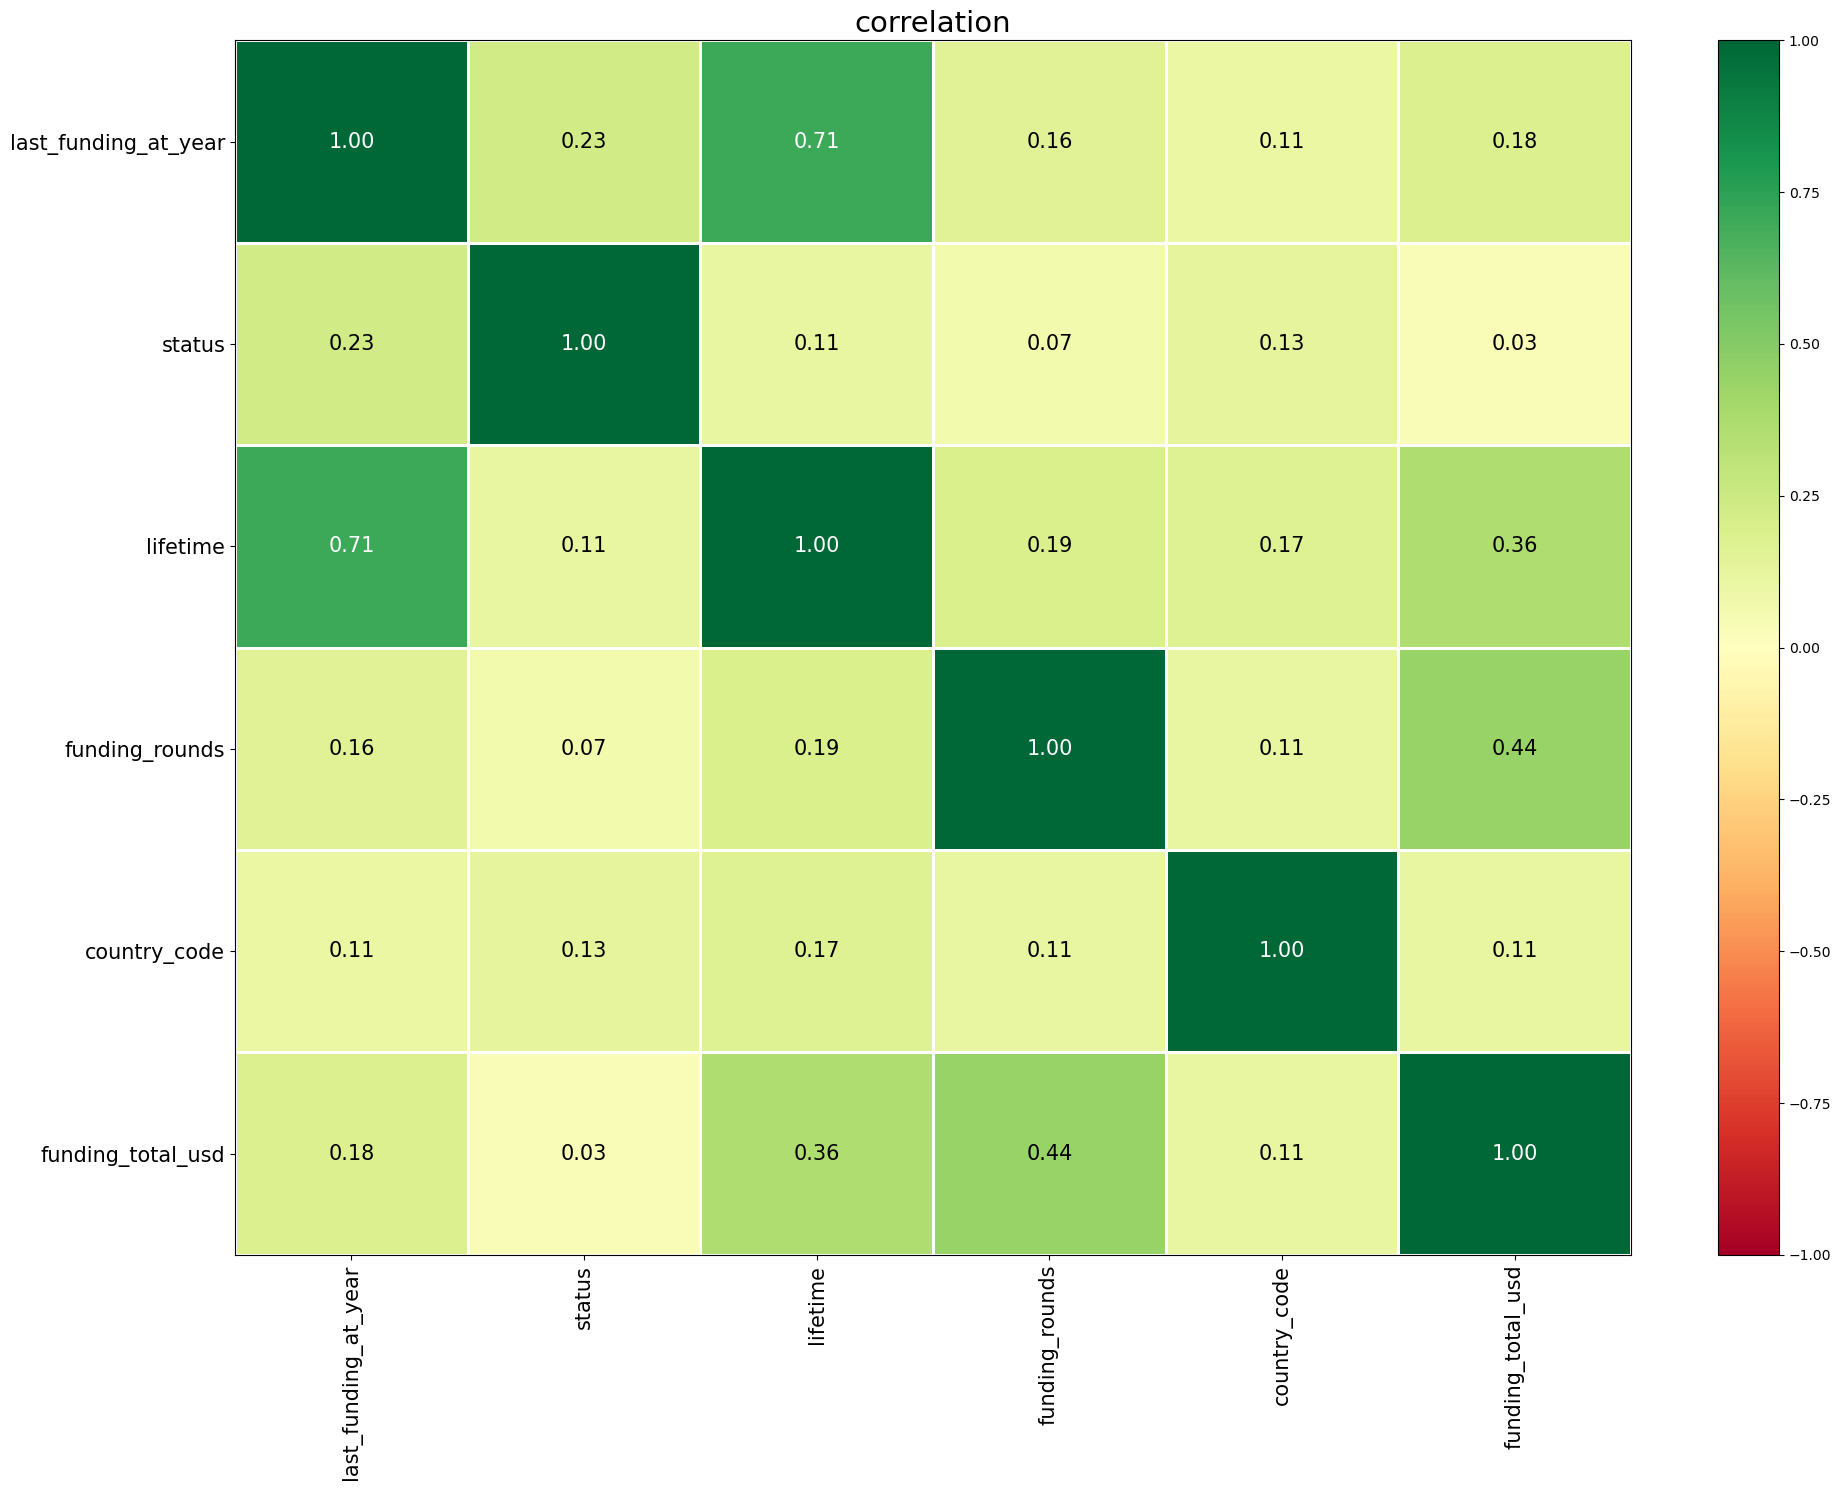

In [49]:
phik_overview = ha.phik_matrix(interval_cols = num_columns)

plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    figsize=(20, 15),
    fontsize_factor=1.5
);

In [50]:
#replaces(df_train['category_list'])

In [51]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50322 entries, 0 to 50321
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  50322 non-null  object 
 1   category_list         47865 non-null  object 
 2   funding_total_usd     40241 non-null  float64
 3   country_code          44882 non-null  object 
 4   funding_rounds        50322 non-null  int64  
 5   lifetime              50322 non-null  int64  
 6   status                50322 non-null  object 
 7   last_funding_at_year  50322 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(4)
memory usage: 2.9+ MB


In [52]:
datetimes(df_test, 'first_funding_at', 'last_funding_at')

In [53]:
df_train.set_index('name', inplace = True)

In [54]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50322 entries, lunchgate to apparcando
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category_list         47865 non-null  object 
 1   funding_total_usd     40241 non-null  float64
 2   country_code          44882 non-null  object 
 3   funding_rounds        50322 non-null  int64  
 4   lifetime              50322 non-null  int64  
 5   status                50322 non-null  object 
 6   last_funding_at_year  50322 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(3)
memory usage: 2.9+ MB


In [55]:
df_train['category_list_1'] = df_train['category_list'].str.split('|').str[0]
df_train['category_list_2'] = df_train['category_list'].str.split('|').str[1]
df_train['category_list_3'] = df_train['category_list'].str.split('|').str[2]

In [56]:
dff_1 = df_train['category_list_1'].value_counts().head(50).index.to_list()
dff_2 = df_train['category_list_2'].value_counts().head(50).index.to_list()
dff_3 = df_train['category_list_3'].value_counts().head(50).index.to_list()

In [57]:
print(len(df_train['category_list_1']))
print(df_train['category_list_1'].shape)
print(df_train['category_list_2'].shape)
print(df_train['category_list_3'].shape)

50322
(50322,)
(50322,)
(50322,)


In [58]:
df_train

,category_list,funding_total_usd,country_code,funding_rounds,lifetime,status,last_funding_at_year,category_list_1,category_list_2,category_list_3
name,,,,,,,,,,
lunchgate,online_reservations|restaurants,828626.0,che,2,2998,operating,2014,online_reservations,restaurants,NaN
earlens,manufacturing|medical|medical_devices,42935019.0,usa,4,4748,operating,2014,manufacturing,medical,medical_devices
reviva pharmaceuticals,biotechnology,35456381.0,usa,3,4383,operating,2014,biotechnology,NaN,NaN
sancilio and company,health_care,22250000.0,NaN,3,5114,operating,2014,health_care,NaN,NaN
wiretough cylinders,manufacturing,NaN,usa,1,2791,operating,2012,manufacturing,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
visionary mobile,biotechnology,1570000.0,usa,3,2922,operating,2012,biotechnology,NaN,NaN
videostream,entertainment,NaN,can,1,2192,operating,2014,entertainment,NaN,NaN
hello curry,hospitality,500000.0,ind,1,1590,operating,2014,hospitality,NaN,NaN


In [59]:
for i, t in enumerate(df_train['category_list_1']):
    if t not in dff_1:
        df_train['category_list_1'] = df_train['category_list_1'].replace(t, 'last')

In [60]:
df_train['category_list_1'].value_counts()

category_list_1
last                      16522
software                   3228
biotechnology              3194
e-commerce                 2087
advertising                1836
curated_web                1706
mobile                     1333
analytics                  1239
apps                       1167
enterprise_software        1039
health_care                1027
clean_technology            991
games                       989
health_and_wellness         925
hardware_+_software         834
finance                     829
education                   786
manufacturing               660
consulting                  558
internet                    486
cloud_computing             462
entertainment               440
social_media                403
android                     388
semiconductors              387
hospitality                 375
real_estate                 373
fashion                     365
automotive                  352
security                    339
big_data                

In [61]:
for i, t in enumerate(df_train['category_list_2']):
    if t not in dff_2:
        df_train['category_list_2'] = df_train['category_list_2'].replace(t, 'last')

In [62]:
df_train['category_list_2'].value_counts()

category_list_2
last                       37115
mobile                       967
software                     890
e-commerce                   721
internet                     546
enterprise_software          497
games                        487
curated_web                  468
education                    443
health_care                  429
social_media                 347
medical                      328
big_data                     326
services                     315
health_and_wellness          314
finance                      312
saas                         284
fashion                      272
fintech                      242
health_diagnostics           242
apps                         239
marketplaces                 238
information_technology       199
manufacturing                198
financial_services           195
news                         191
technology                   186
networking                   178
entertainment                175
design                     

In [63]:
for i, t in enumerate(df_train['category_list_3']):
    if t not in dff_3:
        df_train['category_list_3'] = df_train['category_list_3'].replace(t, 'last')

In [64]:
df_train['category_list_3'].value_counts()

category_list_3
last                      40321
software                    963
mobile                      835
social_media                495
services                    464
technology                  455
saas                        381
internet                    309
enterprise_software         289
marketplaces                266
medical                     253
e-commerce                  238
video                       221
games                       190
social_network_media        189
retail                      180
health_care                 167
travel                      161
education                   155
startups                    151
search                      149
health_and_wellness         146
media                       146
security                    142
fintech                     138
music                       134
curated_web                 133
sales_and_marketing         130
service_providers           129
sports                      127
medical_devices         

## 4. Обучение модели

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    df_train.drop(['status', 'category_list'] , axis=1),
    df_train['status'].apply(lambda x: 1 if x=='closed' else 0),
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
    stratify = df_train['status']
)

#ohe_columns = ['category_list', 'state_code']
#num_columns = ['funding_total_usd', 'funding_rounds', 'lifetime',
#                'first_funding_at_', 'last_funding_at_'
#               ]

num_columns = ['lifetime','funding_total_usd','last_funding_at_year']
ohe_columns = (
    ['country_code',  
     'category_list_1', 'category_list_2', 'category_list_3']
)
poly_columns = ['funding_rounds']

In [66]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

poly_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     #('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns),
     ('poly', poly_pipe, poly_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', CatBoostClassifier(random_state = RANDOM_STATE ))
])

In [67]:
param_grid = [
    
    #{
     #   'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
      #  'models__max_depth': range(4,30),
     #   'models__max_features': range(5,20),
    #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
   # },
   
#    {
 #       'models': [LogisticRegression(
#            random_state=RANDOM_STATE, 
#            solver='liblinear', 
#            penalty='l1'
#        )],
#        'models__C': range(9,10),
 #       'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
 #   },
    {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE)],
   #     'models__iterations': [150,200],
        'models__max_depth': [6, 10, 20, 30, 40, 50, 60],
        'models__n_estimators': [10, 20, 30, 40, 60]
    },
    {
        'models': [LGBMClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [6, 10, 20, 30, 40, 50, 60],
        'models__n_estimators': [10, 20, 30, 40, 60]
        
    }#,
 #   {
 #      'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
 #       'models__max_depth': [10, 20, 30, 40, 50, 60],
 #       'models__n_estimators': [10, 20, 30, 40, 60]
 #   }
]

In [68]:
start = time.time() 
grid = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=5,
    scoring=f1,
    n_jobs=-1
)
grid.fit(X_train, y_train)



display('Лучшая модель и её параметры:\n\n', grid.best_estimator_)
print ('Метрика лучшей модели на кроссвалидационной выборке:', round(grid.best_score_,2))

#y_test_pred = grid.predict(X_test)




grid_search_time = time.time() - start
print(f'Search time:{grid_search_time}')

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
125 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimator.fit(

[LightGBM] [Info] Number of positive: 3608, number of negative: 34133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 966
[LightGBM] [Info] Number of data points in the train set: 37741, number of used features: 211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.095599 -> initscore=-2.247111
[LightGBM] [Info] Start training from score -2.247111


C:\Users\ASUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\ASUS\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


'Лучшая модель и её параметры:\n\n'

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['country_code',
                                                   'category_list_1',
                                                   'category_list_2',
                                                   'category_list_3']),
                                                 ('num', MinMaxScaler(),
                                                  ['lifetime',
                                                   'funding_total_usd',
                                                   'last_funding_at_year']),
                                                 ('poly',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['funding_rounds'])])),
                ('models',
                 LGBMClassifier(max_depth=10, n_estimators=40,
                                random_state=42))])

Метрика лучшей модели на кроссвалидационной выборке: 0.9
Search time:79.43827724456787


In [69]:
y_test_pred = grid.best_estimator_.predict(X_test)
print(f'Метрика f1 на тестовой выборке: {round(f1_score(y_test, y_test_pred, average='micro'),2)}')

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Метрика f1 на тестовой выборке: 0.9


## 5. Shap-analysis 

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


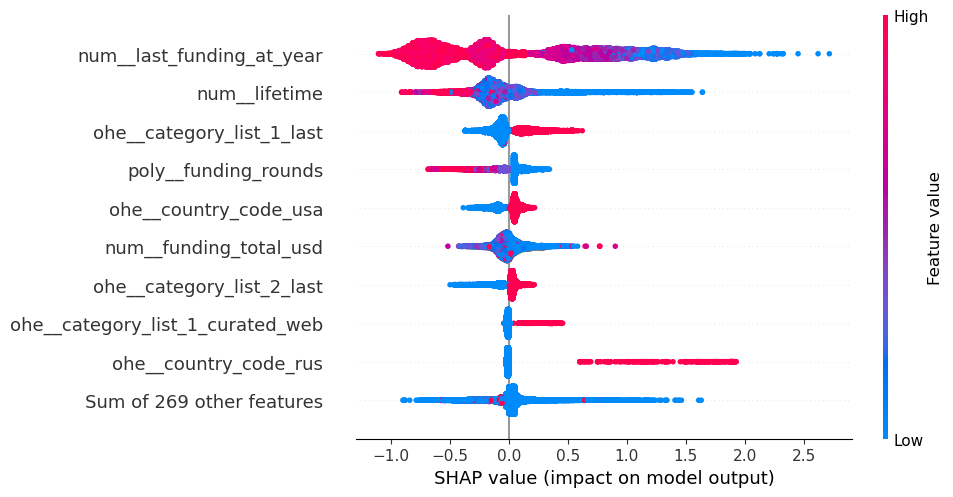

In [70]:
x_Train = grid.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
x_Test = grid.best_estimator_.named_steps['preprocessor'].transform(X_test)
x_Train = pd.DataFrame(x_Train, columns=grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out())
x_Test = pd.DataFrame(x_Test, columns=grid.best_estimator_.named_steps['preprocessor'].get_feature_names_out())

model = grid.best_estimator_.named_steps['models']
explainer = shap.TreeExplainer(model)
shap_values = explainer(x_Train, y_train)
shap.plots.beeswarm(shap_values)


## 6. Подготовка тестовых данных

In [71]:
df['status'] = df['status'].apply(lambda x: 1 if x=='closed' else 0)
df = df.set_index('name')

In [72]:
df_test.set_index('name', inplace = True)

In [73]:
df

,status
name,
Crystalsol,1
JBI Fish & Wings,0
COINPLUS,1
Imagine Communications,1
DNA13,0
...,...
Jymob,0
GlobaTrek,0
Inkd.com,1


In [74]:
df_test

,category_list,funding_total_usd,country_code,funding_rounds,lifetime,last_funding_at_year
name,,,,,,
crystalsol,clean_technology,2819200.0,nic,1,3501,2009
jbi fish & wings,hospitality,NaN,usa,1,2717,2010
coinplus,finance,428257.0,lux,2,1295,2014
imagine communications,software|video|video_streaming,34700000.0,usa,4,4748,2010
dna13,software,4530000.0,can,1,6209,2007
...,...,...,...,...,...,...
jymob,recruiting,28000.0,usa,1,2267,2012
globatrek,software,NaN,usa,1,2192,2013
inkd.com,design|e-commerce|marketplaces|printing,5600000.0,usa,3,2922,2011


In [75]:
#for t in df_test['country_code'].unique():
#    df_test.loc[(df_test['country_code'] == t) & (df_test['funding_total_usd'].isna()), 'funding_total_usd'] = \
#    df_test.loc[(df_test['country_code'] == t), 'funding_total_usd'].median()

In [76]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13125 entries, crystalsol to ringcentral
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   category_list         12534 non-null  object 
 1   funding_total_usd     10547 non-null  float64
 2   country_code          11743 non-null  object 
 3   funding_rounds        13125 non-null  int64  
 4   lifetime              13125 non-null  int64  
 5   last_funding_at_year  13125 non-null  int32  
dtypes: float64(1), int32(1), int64(2), object(2)
memory usage: 666.5+ KB


In [77]:
df_test['category_list_1'] = df_test['category_list'].str.split('|').str[0]
df_test['category_list_2'] = df_test['category_list'].str.split('|').str[1]
df_test['category_list_3'] = df_test['category_list'].str.split('|').str[2]

In [78]:
for i, t in enumerate(df_test['category_list_1']):
    if t not in dff_1:
        df_test['category_list_1'] = df_test['category_list_1'].replace(t, 'last')

In [79]:
for i, t in enumerate(df_test['category_list_2']):
    if t not in dff_2:
        df_test['category_list_2'] = df_test['category_list_2'].replace(t, 'last')

In [80]:
for i, t in enumerate(df_test['category_list_3']):
    if t not in dff_3:
        df_test['category_list_3'] = df_test['category_list_3'].replace(t, 'last')

In [81]:
df_test.drop(['category_list'] , axis=1)

,funding_total_usd,country_code,funding_rounds,lifetime,last_funding_at_year,category_list_1,category_list_2,category_list_3
name,,,,,,,,
crystalsol,2819200.0,nic,1,3501,2009,clean_technology,last,last
jbi fish & wings,NaN,usa,1,2717,2010,hospitality,last,last
coinplus,428257.0,lux,2,1295,2014,finance,last,last
imagine communications,34700000.0,usa,4,4748,2010,software,video,last
dna13,4530000.0,can,1,6209,2007,software,last,last
...,...,...,...,...,...,...,...,...
jymob,28000.0,usa,1,2267,2012,last,last,last
globatrek,NaN,usa,1,2192,2013,software,last,last
inkd.com,5600000.0,usa,3,2922,2011,design,e-commerce,marketplaces


In [82]:
df_test['category_list_1'].value_counts()

category_list_1
last                      4308
biotechnology              855
software                   809
e-commerce                 566
advertising                456
curated_web                436
mobile                     374
analytics                  317
clean_technology           299
apps                       290
health_care                282
games                      265
enterprise_software        248
health_and_wellness        244
finance                    234
hardware_+_software        219
education                  190
manufacturing              183
consulting                 145
android                    138
internet                   125
entertainment              120
hospitality                111
cloud_computing            108
semiconductors             102
security                    96
fashion                     95
real_estate                 94
business_services           93
automotive                  92
social_media                90
web_hosting            

In [83]:
df_test['category_list_2'].value_counts()

category_list_2
last                       9588
mobile                      252
software                    228
e-commerce                  159
health_care                 150
education                   149
games                       140
internet                    134
enterprise_software         119
curated_web                 118
social_media                 96
health_and_wellness          91
services                     87
big_data                     84
apps                         80
fashion                      80
marketplaces                 76
finance                      72
health_diagnostics           66
medical                      65
technology                   64
manufacturing                62
fintech                      61
saas                         61
information_technology       51
financial_services           51
events                       49
entertainment                48
news                         46
media                        46
cloud_computing         

In [84]:
df_test['category_list_3'].value_counts()

category_list_3
last                      10531
software                    246
mobile                      227
social_media                147
technology                  136
services                    110
medical                      87
saas                         83
enterprise_software          74
internet                     72
marketplaces                 66
e-commerce                   65
social_network_media         48
games                        45
health_and_wellness          42
curated_web                  42
fashion                      42
medical_devices              40
startups                     40
education                    40
travel                       39
information_technology       38
networking                   38
video                        37
health_care                  37
pharmaceuticals              36
iphone                       35
manufacturing                35
sports                       35
retail                       34
mobile_commerce         

## 7. Предсказание модели и сравнение

In [85]:
df_test = grid.best_estimator_.named_steps['preprocessor'].transform(df_test)
df_test_predict = model.predict(df_test)

C:\Users\ASUS\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [86]:
print(f'Метрика f1 на тестовых данных: {round(f1_score(df, df_test_predict, average='micro'),2)}')

Метрика f1 на тестовых данных: 0.51


In [87]:
df

,status
name,
Crystalsol,1
JBI Fish & Wings,0
COINPLUS,1
Imagine Communications,1
DNA13,0
...,...
Jymob,0
GlobaTrek,0
Inkd.com,1


## Вывод


**Разработали модель для предсказаний.  
Лучшая модель: LGBMClassifier(max_depth=20, n_estimators=60, random_state=42)
На закрытие компании влияют следующие признаки: время существования компании, дата последнего финансирования,
сумма финансирования и количество раундов финансирования**